## US data monitor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # HP filter and OLS regression
import datetime

In [2]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 2.5

In [3]:
pd.set_option('display.precision', 2)

In [4]:
import data_monitor_load

## Data load

Load data, can use either `same_def` or `own_def` for own deflator

In [5]:
series = data_monitor_load.get_fred_data('Q','own_def')

In [6]:
seriesm = data_monitor_load.get_fred_data('M','own_def')

In [7]:
seriesd = data_monitor_load.get_fred_data('D','own_def')

### Quick look at the latest data

In [8]:
def get_latest_series(ser, name):
    # Extract latest available datapoint from a series
    # Store latest date and value, index using 'name'
    latest = ser[ser.notnull()].tail(1)
    latest= pd.DataFrame(latest).assign(name=name).reset_index().set_index('name')
    latest.columns = ['date_latest', 'value_latest']
    pre_latest = ser[ser.notnull()].tail(2).head(1)
    pre_latest= pd.DataFrame(pre_latest).assign(name=name).reset_index().set_index('name')
    pre_latest.columns = ['date_previous', 'value_previous']
    pre_latest.drop(['date_previous'], axis=1, inplace=True)
    return latest.join(pre_latest)

def plot_latest(servals, sernames):
    # show table with latest variables in servals, with names in sernames
    latest = sernames # Declare a list with same names
    for i, sername in enumerate(sernames):
        latest[i]=get_latest_series(servals[i], sername)
    display(pd.concat(latest))

In [9]:
gdppercapita =  1000000*series['yn']/series['pop']
yoygrowth = 100* np.log(series['y']).diff(4)
qoqgrowth = 400* np.log(series['y']).diff(1)

prodyoygrowth = 100* np.log(series['labprod']).diff(4)

nomyoygrowth = 100* np.log(series['yn']).diff(4)
cpiinfl = 100*(seriesm['cpi']-seriesm['cpi'].shift(12))/seriesm['cpi'].shift(12)
pceinfl = 100*(seriesm['pcedefl']-seriesm['pcedefl'].shift(12))/seriesm['pcedefl'].shift(12)

cpiinfl_core = 100*(seriesm['cpicore']-seriesm['cpicore'].shift(12))/seriesm['cpicore'].shift(12)
pceinfl_core = 100*(seriesm['pcedeflcore']-seriesm['pcedeflcore'].shift(12))/seriesm['pcedeflcore'].shift(12)

winfl = 100*(seriesm['w_ces']-seriesm['w_ces'].shift(12))/seriesm['w_ces'].shift(12) # average hourly earnings all from CES
ecig = 100*(series['eci']-series['eci'].shift(4))/series['eci'].shift(4) # growth in employment cost index

nonfarm_ch = seriesm['emp']-seriesm['emp'].shift(1)

nompcegrowth = 100*(seriesm['pcemonthly']-seriesm['pcemonthly'].shift(12))/seriesm['pcemonthly'].shift(12)
realpce = seriesm['pcemonthly']/seriesm['pcedefl']
pcegrowth = 100*(realpce-realpce.shift(12))/realpce.shift(12)

#### GDP, growth and productivity

In [10]:
servals   = [series['yn']/1000, gdppercapita, qoqgrowth, yoygrowth, 
             pcegrowth, prodyoygrowth]
sernames  = ['nominal GDP $trn', 'GDP per person $', 'real GDP growth QoQ', 'real GDP growth YoY', 
             'real PCE growth YoY', 'labor productivity growth YoY']

plot_latest(servals, sernames)

,date_latest,value_latest,value_previous
name,,,
nominal GDP $trn,2022-12-31,26.13,25.72
GDP per person $,2022-12-31,78191.16,77084.39
real GDP growth QoQ,2022-12-31,2.85,3.19
real GDP growth YoY,2022-12-31,0.95,1.92
real PCE growth YoY,2022-11-30,2.02,1.91
labor productivity growth YoY,2022-09-30,-1.26,-2.08


Double check these numbers against
- [GDP release](https://www.bea.gov/data/gdp/gross-domestic-product) (last Thursday of each month, cycling through Advance-Second-Third. Advance estimate after each end Q comes 4 months later)
- [Personal income and outlays](https://www.bea.gov/data/consumer-spending/main) (last Friday of each month for prev month)
- [Productivity and costs release](https://www.bls.gov/news.release/prod2.nr0.htm) (first Thursday of each month for quarter currently covered by GDP release)

#### Employment and unemployment

In [11]:
servals   = [seriesm['u'], seriesm['epop'],seriesm['partrate'], seriesm['ulevel']/1000, seriesm['jobopenings']/1000, seriesm['emp']/1000, nonfarm_ch]
sernames  = ['unemployment rate (%LF)', 'LFPR (%Pop)', 'employment-pop', 'unemployment level (million)', 'job openings (million)', 'nonfarm payrolls (million)', 'chg in nonfarm payrolls (000s)']

plot_latest(servals, sernames)

,date_latest,value_latest,value_previous
name,,,
unemployment rate (%LF),2022-12-31,3.50,3.60
LFPR (%Pop),2022-12-31,60.10,59.90
employment-pop,2022-12-31,62.30,62.20
unemployment level (million),2022-12-31,5.72,6.00
job openings (million),2022-11-30,10.46,10.51
nonfarm payrolls (million),2022-12-31,153.74,153.52
chg in nonfarm payrolls (000s),2022-12-31,223.00,256.00


Double check these numbers against
- [Employment situation summary, household data](https://www.bls.gov/news.release/empsit.a.htm) (first Friday of each month for previous month data)
- [JOLTS release](https://www.bls.gov/news.release/jolts.nr0.htm) (last Tuesday of each month, covering employment in the month prior)

#### Inflation and interest rates

In [12]:
servals   = [cpiinfl, pceinfl, cpiinfl_core, pceinfl_core, winfl, ecig, seriesd['fedfunds'], seriesd['dgs10'], seriesd['breakeven10']]
sernames  = ['CPI inflation YoY', 'PCE inflation YoY', 'CPI inflation YoY (core)', 'PCE inflation YoY (core)',  'Wage inflation (CES AHE)', 'ECI growth', 'Fed Funds rate', '10 year treasury', '10 year breakeven']

plot_latest(servals, sernames)
#extra = [qoqgrowth,nomyoygrowth, nompcegrowth]
#sernames_extra = ['real GDP growth QoQ (annualized)', 'nominal GDP growth YoY', 'nominal PCE growth YoY']


,date_latest,value_latest,value_previous
name,,,
CPI inflation YoY,2022-12-31,6.42,7.12
PCE inflation YoY,2022-11-30,5.54,6.08
CPI inflation YoY (core),2022-12-31,5.69,5.96
PCE inflation YoY (core),2022-11-30,4.68,5.05
Wage inflation (CES AHE),2022-12-31,4.59,4.80
ECI growth,2022-09-30,5.05,5.04
Fed Funds rate,2023-01-24,4.33,4.33
10 year treasury,2023-01-24,3.46,3.52
10 year breakeven,2023-01-25,2.29,2.27


Double check these numbers against
- [Personal income and outlays](https://www.bea.gov/data/consumer-spending/main) (last Friday of each month for prev month)
- [CPI release](https://www.bls.gov/news.release/cpi.nr0.htm) (around second Wednesday of each month)

See [BEA schedule](https://www.bea.gov/news/schedule)  for more details, as well as their new [macro snapshot](https://stlouisfed.shinyapps.io/macro-snapshot/#home)

### Plotting area

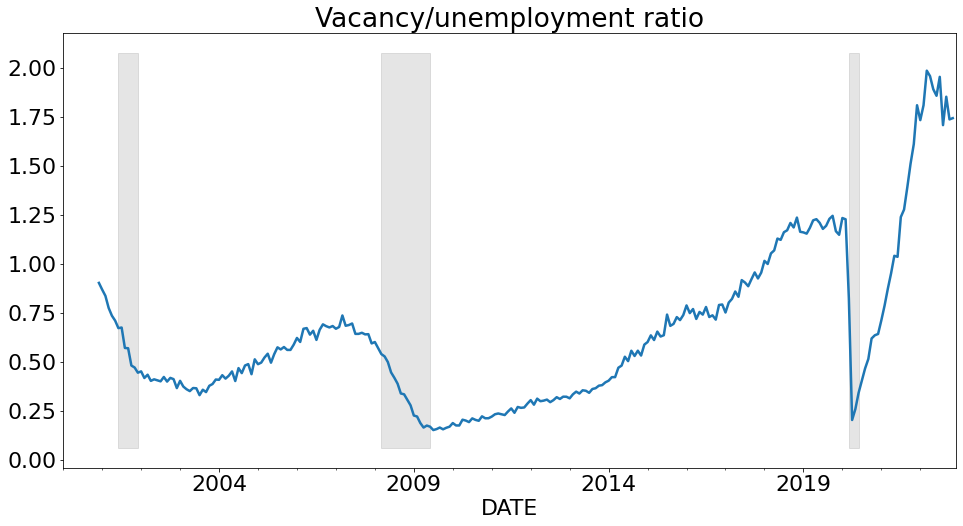

In [13]:
vu =  seriesm['jobopenings']/seriesm['ulevel']
vu.plot()
yl, yh = plt.ylim()
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
plt.xlim('2000-01-01', '2022-12-01')
plt.title('Vacancy/unemployment ratio')
plt.show()

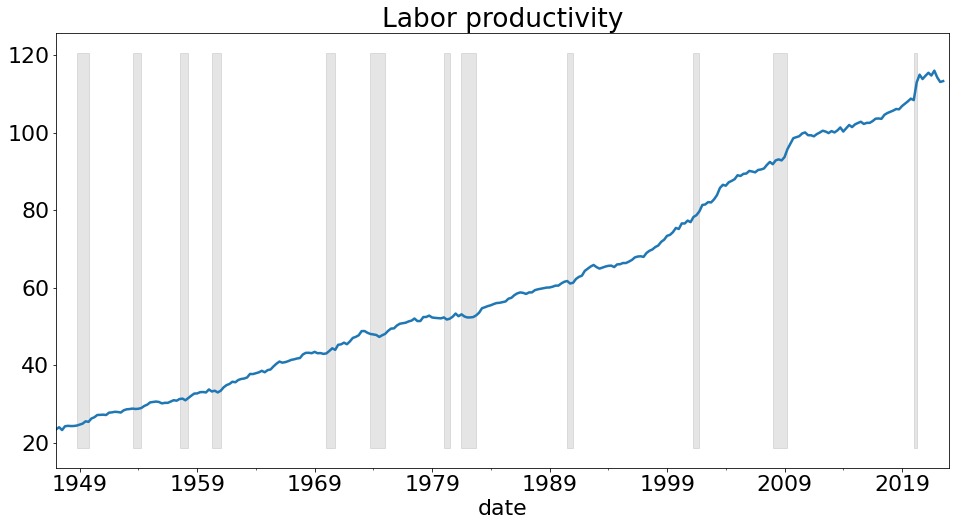

In [14]:
series['labprod'].plot()
yl, yh = plt.ylim()
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
#plt.xlim('2000-01-01', '2022-12-01')
plt.title('Labor productivity')
plt.show()

In [15]:
data_monitor_load.decadal_average_growth(series['labprod'], dec=True)

Average for 1950s : 0.0228
Average for 1960s : 0.024
Average for 1970s : 0.0191
Average for 1980s : 0.0146
Average for 1990s : 0.021
Average for 2000s : 0.0271
Average for 2010s : 0.0096


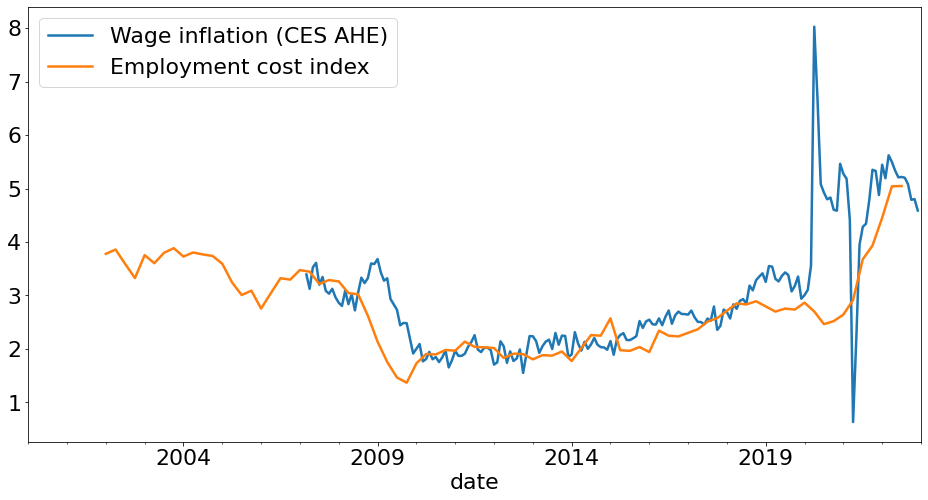

In [16]:
winfl.plot(label='Wage inflation (CES AHE)')
ecig.plot(label='Employment cost index')
plt.xlim('2000-01-01','2023-01-01')
plt.legend();

# More plots

#### Sample selection

In [17]:
series=series.loc['1952-03-31':'2022-06-30']
seriesm=seriesm.loc['1952-03-31':]
series.tail()

,yn,cn,gn,in,nxn,impn,expn,y,c,g,...,w_ces,eci,u,epop,partrate,ulevel,jobopenings,USREC,dgs10,breakeven10
date,,,,,,,,,,,,,,,,,,,,,
2021-06-30,23046.93,15813.55,4124.38,3943.40,-834.40,3337.49,2503.09,19544.25,13773.69,3422.36,...,30.36,144.8,5.93,57.97,61.60,9500.67,9585.33,0.0,1.59,2.38
2021-09-30,23550.42,16147.30,4183.14,4109.12,-889.14,3442.48,2553.33,19672.59,13874.40,3421.05,...,30.78,146.6,5.13,58.60,61.73,8235.00,10695.00,0.0,1.32,2.34
2021-12-31,24349.12,16517.98,4246.68,4499.17,-914.71,3647.74,2733.04,20006.18,13981.51,3412.86,...,31.24,148.0,4.20,59.30,61.90,6818.00,11154.67,0.0,1.53,2.53
2022-03-31,24740.48,16874.77,4311.37,4671.03,-1116.68,3927.91,2811.22,19924.09,14028.38,3393.39,...,31.64,150.1,3.80,59.87,62.27,6251.67,11494.00,0.0,1.95,2.60
2022-06-30,25248.48,17261.34,4412.78,4609.93,-1035.57,4074.41,3038.84,19895.27,14099.46,3379.50,...,31.98,152.1,3.60,59.93,62.23,5964.00,11341.33,0.0,2.93,2.73


#### Construct extra variables

In [18]:
NQ=series.index.size # Number of quarters in data
series['ypop']=series['y']/series['pop'] # Output per person
series['t']=np.arange(0,NQ) # Quarter counter

In [19]:
print('Total quarters = ', NQ)

Total quarters =  282


#### Let's start with GDP

Start by looking at US log real GDP since 1952

Text(0.5, 1.0, 'U.S. real GDP ($Y_t$)')

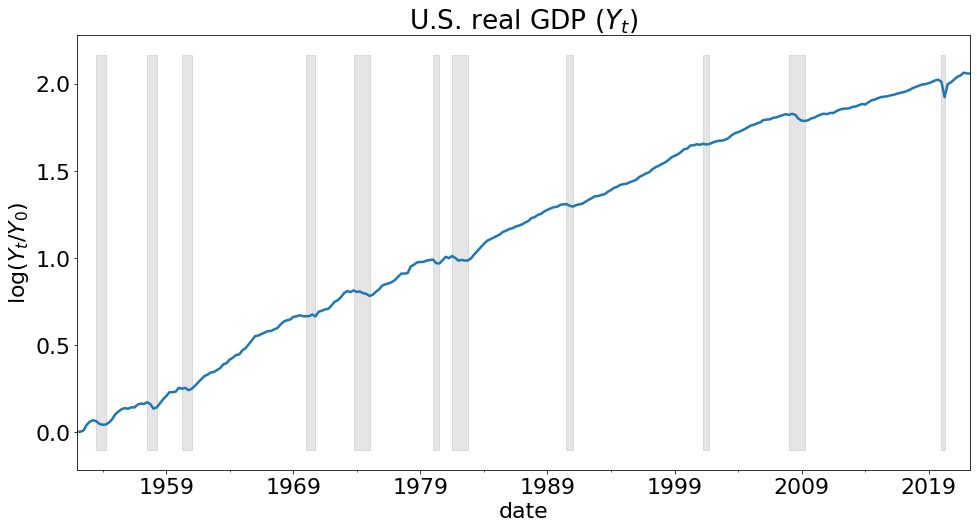

In [20]:
(np.log(series['y'])-np.log(series['y'][0])).plot()
yl, yh = plt.ylim()
plt.ylabel(r'$\log(Y_t/Y_{0})$')
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
plt.title(r'U.S. real GDP ($Y_t$)')
#plt.savefig(f'Export/us_log_gdp.pdf', format='pdf', transparent=True);

Over 70 years, we've grown by 2 log points, since $e^2=7.4$, we've multiplied real GDP by 7.5

In [21]:
print('Annualized log growth rate of nominal GDP =',(np.log(series['yn'][-1])-np.log(series['yn'][0]))/(NQ/4))
print('Annualized log growth rate of real GDP    =',(np.log(series['y'][-1])-np.log(series['y'][0]))/(NQ/4))
print('Annualized log growth rate of population  =',(np.log(series['pop'][-1])-np.log(series['pop'][0]))/(NQ/4))

Annualized log growth rate of nominal GDP = 0.060296697447345615
Annualized log growth rate of real GDP    = 0.029183239560649395
Annualized log growth rate of population  = 0.010719096549868051


In [22]:
data_monitor_load.decadal_average_growth(series['y'], dec=True)

Average for 1950s : 0.029
Average for 1960s : 0.0412
Average for 1970s : 0.0323
Average for 1980s : 0.0303
Average for 1990s : 0.0319
Average for 2000s : 0.0173
Average for 2010s : 0.0218


In [23]:
data_monitor_load.decadal_average_growth(series['pop'], dec=True)

Average for 1950s : 0.0167
Average for 1960s : 0.0125
Average for 1970s : 0.0102
Average for 1980s : 0.0091
Average for 1990s : 0.012
Average for 2000s : 0.0092
Average for 2010s : 0.0063


Text(0, 0.5, '$100 \\Delta \\log(Y_t)$')

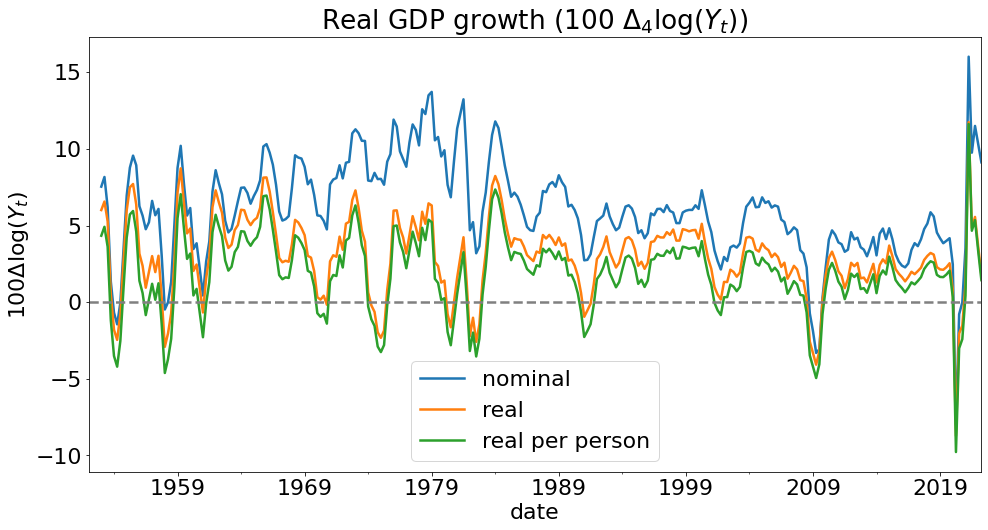

In [24]:
(100* np.log(series['yn']).diff(4)).plot(label='nominal')
(100* np.log(series['y']).diff(4)).plot(label='real')
(100*np.log(series['ypop']).diff(4)).plot(label='real per person')
plt.title(r"Real GDP growth (100 $\Delta_4 \log(Y_t)$)")
plt.axhline(0, linestyle='--', color='gray')
plt.legend()
#plt.xlim(1960,2020)
#plt.ylim(-1,13)
plt.ylabel(r'$100 \Delta \log(Y_t)$')
#plt.savefig(f'Export/us_log_infl.pdf', format='pdf', transparent=True);

In [25]:
data_monitor_load.decadal_average_growth(series['pop'])

Average for 1950/60 : 0.0146
Average for 1970/80 : 0.0106
Average for 2000/10 : 0.0079


In [26]:
series['pop'][0]

156522.33333333334

In [27]:
series['pop'][-1]

333250.684

### Unemployment and Employment

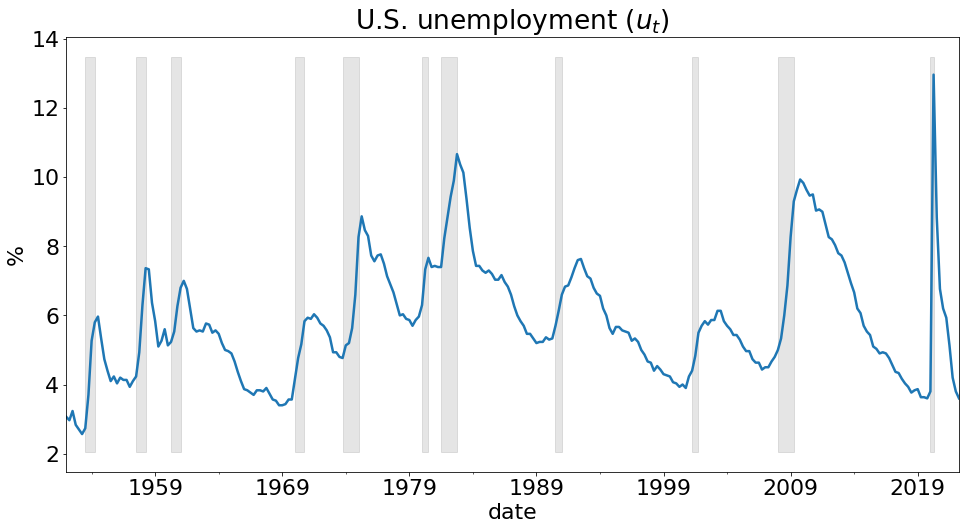

In [28]:
series['u'].plot()
yl, yh = plt.ylim()
plt.ylabel('%')
#plt.legend()
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
plt.title(r'U.S. unemployment ($u_t$)')
plt.show()
#plt.savefig(f'Export/us_unempl.pdf', format='pdf', transparent=True);

Employment-population to visualize how much we've recovered from collapse in participation in recession

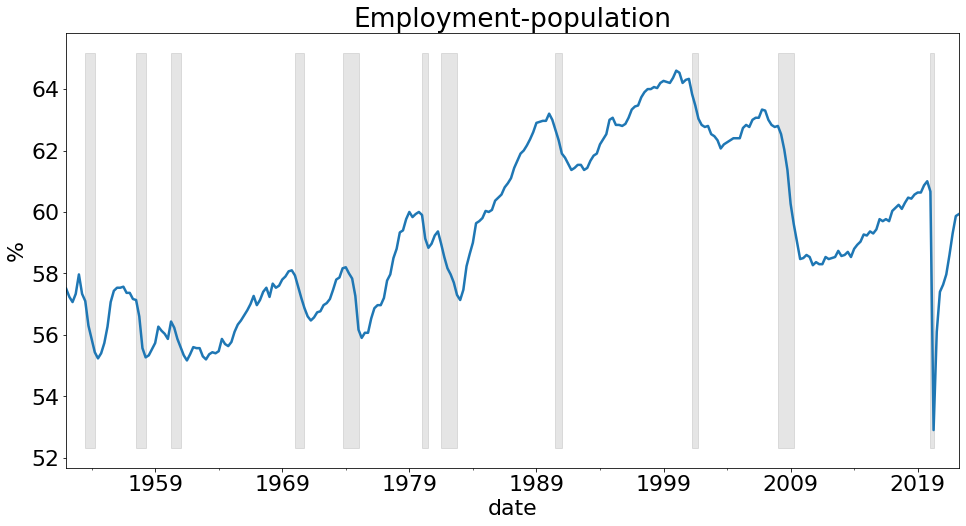

In [29]:
series['epop'].plot()
yl, yh = plt.ylim()
plt.ylabel('%')
#plt.legend()
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
plt.title(r'Employment-population')
plt.show()

### Contributions to growth in each recession

Verify national accounting identity in original nominal series

In [30]:
series["sumyn"]=series["cn"]+series["in"]+series["gn"]+series["expn"]-series["impn"]
np.max((series["yn"]-series["sumyn"])/series["yn"])

2.946922970478305e-06

So this is accurate to the 6th digit

Do this at a monthly level and with the same deflator everywhere, so as to preserve adding up

In [31]:
seriesm_same = data_monitor_load.get_fred_data('M','same_def')

Check that we do add up all components

In [32]:
seriesm_same["sumyn"]=seriesm_same["cn"]+seriesm_same["in"]+seriesm_same["gn"]+seriesm_same["expn"]-seriesm_same["impn"]
np.max((seriesm_same["yn"]-seriesm_same["sumyn"])/seriesm_same["yn"])

3.6951228075291693e-06

Construct indicator = 1 if recession begins this month, -1 if it ends this month

In [33]:
seriesm_same["USREC"].loc['1948-10-31':'1949-01-31']

DATE
1948-10-31    0.0
1948-11-30    0.0
1948-12-31    1.0
1949-01-31    1.0
Freq: M, Name: USREC, dtype: float64

Note the official NBER [webpage](https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions) says that the peak was in November 1948 and trough in October 1949, so make sure our dating is consistent with that

In [34]:
begrec=seriesm_same["USREC"].diff().shift(-1)

In [35]:
begrec.loc['1948-10-31':'1949-01-31']

DATE
1948-10-31    0.0
1948-11-30    1.0
1948-12-31    0.0
1949-01-31    0.0
Freq: M, Name: USREC, dtype: float64

In [36]:
begrec.loc['1949-09-30':'1949-12-31']

DATE
1949-09-30    0.0
1949-10-31   -1.0
1949-11-30    0.0
1949-12-31    0.0
Freq: M, Name: USREC, dtype: float64

Now store beginning and ends

In [37]:
beg=seriesm_same.loc[(begrec==1).to_numpy()].rename(columns={"y":"y_start", "i":"i_start", "c":"c_start", "g":"g_start", "imp":"imp_start", "exp":"exp_start"})

In [38]:
end=seriesm_same.loc[(begrec==-1).to_numpy()].rename(columns={"y":"y_end", "i":"i_end", "c":"c_end", "g":"g_end", "imp":"imp_end", "exp":"exp_end"})

Add date to `end`

In [39]:
end["date_end"]=end.index

In [40]:
end['y_end']

DATE
1949-10-31     2103.75
1954-05-31     2664.49
1958-04-30     2927.36
1961-02-28     3274.40
1970-11-30     4984.01
1975-03-31     5578.28
1980-07-31     6693.10
1982-11-30     6836.95
1991-03-31     9323.60
2001-11-30    13321.67
2009-06-30    15198.41
2020-04-30    17378.71
Name: y_end, dtype: float64

In [41]:
startend=pd.concat([beg[["y_start","i_start", "c_start", "g_start", "imp_start", "exp_start"]],end[["y_end","i_end", "c_end", "g_end", "imp_end", "exp_end","date_end"]]])

In [42]:
startend.sort_index(inplace=True)

In [43]:
for i in ["y_end","i_end", "c_end", "g_end","imp_end", "exp_end", "date_end"]:
    startend[i]=startend[i].shift(-1)

In [44]:
startend.dropna(inplace=True)

In [45]:
startend.head()

,y_start,i_start,c_start,g_start,imp_start,exp_start,y_end,i_end,c_end,g_end,imp_end,exp_end,date_end
DATE,,,,,,,,,,,,,
1948-11-30,2126.69,371.02,1355.47,360.80,75.96,115.35,2103.75,291.26,1401.19,387.98,70.68,93.99,1949-10-31
1953-07-31,2705.19,424.86,1615.95,668.20,112.77,108.96,2664.49,389.10,1640.22,632.70,109.20,111.68,1954-05-31
1957-08-31,3006.59,481.70,1819.81,681.22,124.05,147.91,2927.36,403.55,1816.16,704.73,124.51,127.43,1958-04-30
1960-04-30,3260.11,524.77,2001.61,713.26,141.32,161.78,3274.40,479.27,2006.72,755.51,129.77,162.66,1961-02-28
1969-12-31,4942.24,799.12,2964.76,1162.35,252.04,268.06,4984.01,786.94,3008.59,1172.62,262.45,278.31,1970-11-30


In [46]:
startend["dy"]=100*(startend['y_end']-startend['y_start'])/startend['y_start']
startend["dc"]=100*(startend['c_end']-startend['c_start'])/startend['y_start']
startend["di"]=100*(startend['i_end']-startend['i_start'])/startend['y_start']
startend["dg"]=100*(startend['g_end']-startend['g_start'])/startend['y_start']
startend["dexp"]=100*(startend['exp_end']-startend['exp_start'])/startend['y_start']
startend["-dimp"]=-100*(startend['imp_end']-startend['imp_start'])/startend['y_start']
startend["sum"]=startend["dc"]+startend["di"]+startend["dg"]+startend["dexp"]+startend["-dimp"]

## Now show contribution to growth in each recession

In [47]:
startend[["date_end","dy","dc","di","dg","dexp","-dimp"]].round(1)

,date_end,dy,dc,di,dg,dexp,-dimp
DATE,,,,,,,
1948-11-30,1949-10-31,-1.1,2.1,-3.8,1.3,-1.0,0.2
1953-07-31,1954-05-31,-1.5,0.9,-1.3,-1.3,0.1,0.1
1957-08-31,1958-04-30,-2.6,-0.1,-2.6,0.8,-0.7,-0.0
1960-04-30,1961-02-28,0.4,0.2,-1.4,1.3,0.0,0.4
1969-12-31,1970-11-30,0.8,0.9,-0.2,0.2,0.2,-0.2
1973-11-30,1975-03-31,-2.4,0.4,-4.2,0.8,0.8,-0.1
1980-01-31,1980-07-31,-2.2,-0.6,-2.9,-0.1,0.1,1.3
1981-07-31,1982-11-30,-2.1,1.6,-4.2,1.0,-1.6,1.1
1990-07-31,1991-03-31,-0.9,-0.4,-1.6,0.4,0.3,0.5


Typical patterns:
   - C accounts for half of GDP decline in most recessions (was 2/3 in the last)
   - I accounts for typicall all of GDP decline
   - G and import decline offset about a half
   - Exports are typically fairly acyclical

###  Inflation data

In [48]:
yoy=100*(seriesm['cpi']-seriesm['cpi'].shift(12))/seriesm['cpi'].shift(12)
pceyoy=100*(seriesm['pcedefl']-seriesm['pcedefl'].shift(12))/seriesm['pcedefl'].shift(12)
wyoy=100*(seriesm['w_ces']-seriesm['w_ces'].shift(12))/seriesm['w_ces'].shift(12)
wprodyoy=100*(series['w']-series['w'].shift(4))/series['w'].shift(4)

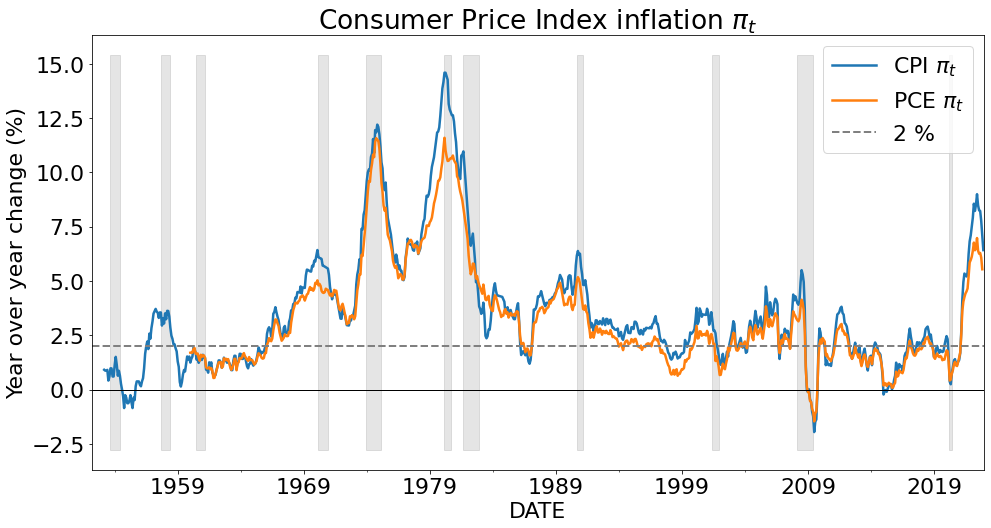

In [49]:
plt.figure
yoy.plot(label=r'CPI $\pi_t$')
pceyoy.plot(label=r'PCE $\pi_t$')
#wyoy.plot(label=r'CES Wage inflation $\pi_{wt}$')
#wprodyoy.plot(label=r'Wage inflation $\pi_{wt}$')
yl, yh = plt.ylim()
plt.title(r'Consumer Price Index inflation $\pi_t$')
plt.ylabel(r'Year over year change (%)')
plt.axhline(2, linestyle='--', color='gray', linewidth=2, label=r'2 %')
plt.legend()
plt.axhline(0, color='black', linewidth=1)
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
#plt.savefig(f'Export/us_infl.pdf', format='pdf', transparent=True);

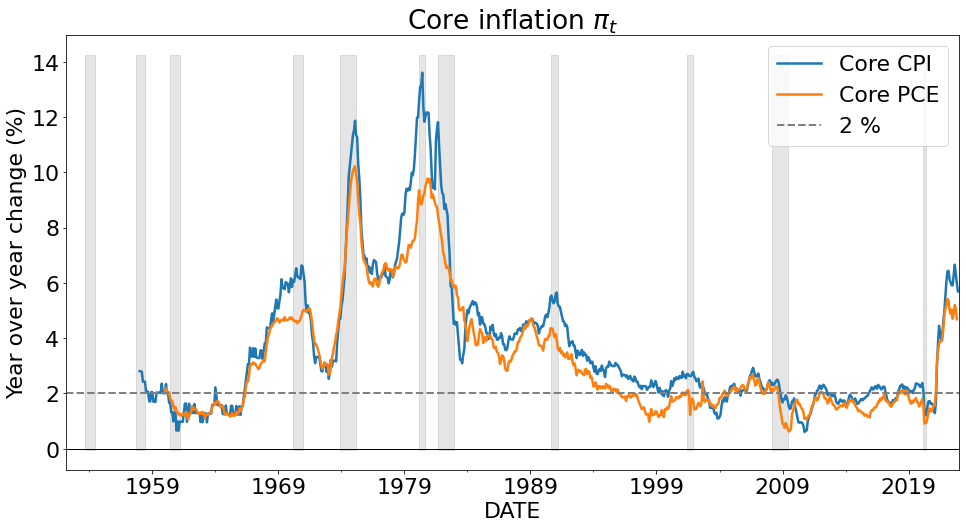

In [50]:
yoycore=100*(seriesm['cpicore']-seriesm['cpicore'].shift(12))/seriesm['cpicore'].shift(12)
pceyoycore=100*(seriesm['pcedeflcore']-seriesm['pcedeflcore'].shift(12))/seriesm['pcedeflcore'].shift(12)

plt.figure
yoycore.plot(label=r'Core CPI')
pceyoycore.plot(label=r'Core PCE')
yl, yh = plt.ylim()
plt.title(r'Core inflation $\pi_t$')
plt.ylabel(r'Year over year change (%)')
plt.axhline(2, linestyle='--', color='gray', linewidth=2, label=r'2 %')
plt.legend()
plt.axhline(0, color='black', linewidth=1)
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
#plt.savefig(f'Export/us_infl.pdf', format='pdf', transparent=True);

Text(0.5, 1.0, 'Real wages and labor productivity')

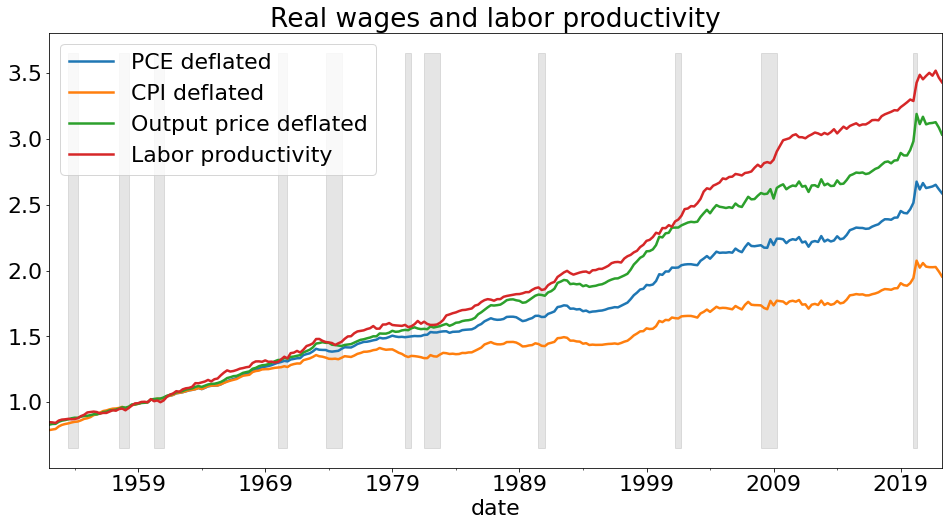

In [51]:
realwpce=series['w']/series['pcedefl']
realwcpi=series['w']/series['cpi']
realwdefl=series['w']/series['ydefl_nonfarm']

realwpce=1*realwpce/realwpce.loc['1959-12-31']
realwcpi=1*realwcpi/realwcpi.loc['1959-12-31']
realwdefl=1*realwdefl/realwdefl.loc['1959-12-31']
labprod=1*series['labprod']/series['labprod'].loc['1959-12-31']

plt.figure
realwpce.plot(label=r'PCE deflated')
realwcpi.plot(label=r'CPI deflated')
realwdefl.plot(label=r'Output price deflated')
labprod.plot(label=r'Labor productivity')

yl, yh = plt.ylim()
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
#plt.savefig(f'Export/us_infl.pdf', format='pdf', transparent=True);
plt.legend()
plt.title('Real wages and labor productivity')

So labor productivity (output per hour $Y/N$) growth roughly in line with growth of real wages $W/P$, but only if you look at the price index for nonfarm business. Why? that price deflator grows much less quickly than PCE and especially CPI, and this compounds to create a big gap. 

In [52]:
ulcyoy=series['ulc'] # This is already % change from quarter one year ago
cpiyoyq=100*(series['cpi']-series['cpi'].shift(4))/series['cpi'].shift(4)
deflyoyq=100*(series['ydefl_nonfarm']-series['ydefl_nonfarm'].shift(4))/series['ydefl_nonfarm'].shift(4)

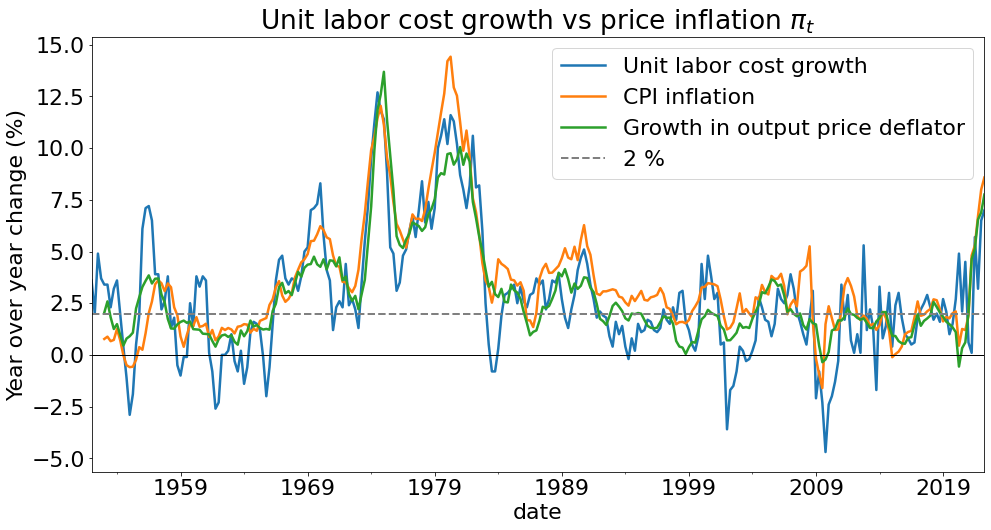

In [53]:
plt.figure
ulcyoy.plot(label=r'Unit labor cost growth')
cpiyoyq.plot(label=r'CPI inflation')
deflyoyq.plot(label=r'Growth in output price deflator')
yl, yh = plt.ylim()
plt.title(r'Unit labor cost growth vs price inflation $\pi_t$')
plt.ylabel(r'Year over year change (%)')
plt.axhline(2, linestyle='--', color='gray', linewidth=2, label=r'2 %')
plt.legend()
plt.axhline(0, color='black', linewidth=1)

Transform this to logs quarter on quarter growth (so $u_{t+4}-u_t$)

In [54]:
cumulc_cpi_diff= (ulcyoy-cpiyoyq).cumsum(axis=0)/4

In [55]:
logulcg=np.log(1+ulcyoy/100)
logcpig=np.log(series['cpi'])-np.log(series['cpi'].shift(4))
logdeflg=np.log(series['ydefl_nonfarm'])-np.log(series['ydefl_nonfarm'].shift(4))

Form $log(W_t N_t/P_tY_t)-log(W_0 N_0/P_0 Y_0)$. 

Since this is QoQ growth, we divide by 4 to get (average of last 4 terms)-average of first 4 terms in the telescoping sum

In [56]:
logch=100*np.cumsum(logulcg-logcpig)/4
alt1 = (100*(np.log(realwcpi)-np.log(labprod))) # Using real wage minus productivity
alt1=alt1-alt1.loc['1953-03-31'] # Center at same start date

logch_ydefl=100*np.cumsum(logulcg-logdeflg)/4

labsh=100*(np.log(series['laborshare'])-np.log(series['laborshare'].loc['1953-03-31']))

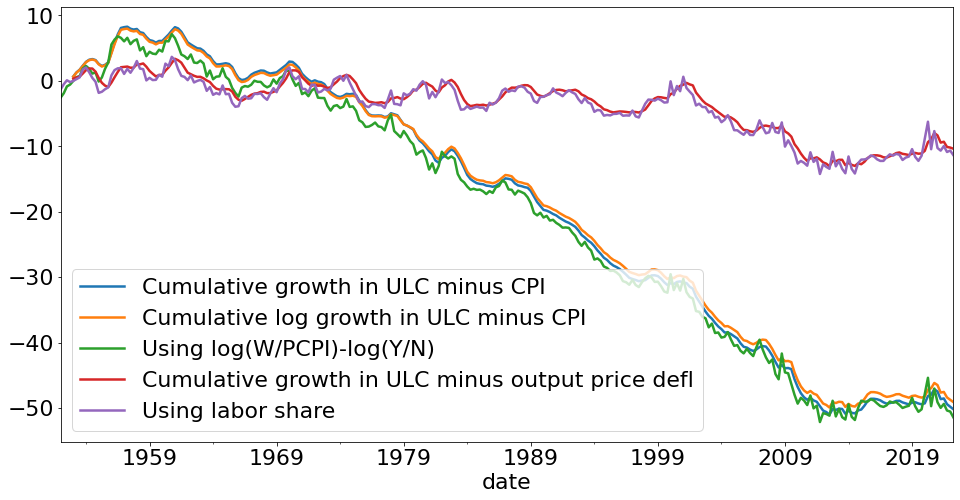

In [57]:
plt.figure
cumulc_cpi_diff.plot(label=r'Cumulative growth in ULC minus CPI')
logch.plot(label=r'Cumulative log growth in ULC minus CPI')
alt1.plot(label=r'Using log(W/PCPI)-log(Y/N)')

logch_ydefl.plot(label=r'Cumulative growth in ULC minus output price defl')

labsh.plot(label=r'Using labor share')

plt.legend()

So this makes a really big difference! Now, study the cyclicality of the labor share some more. 

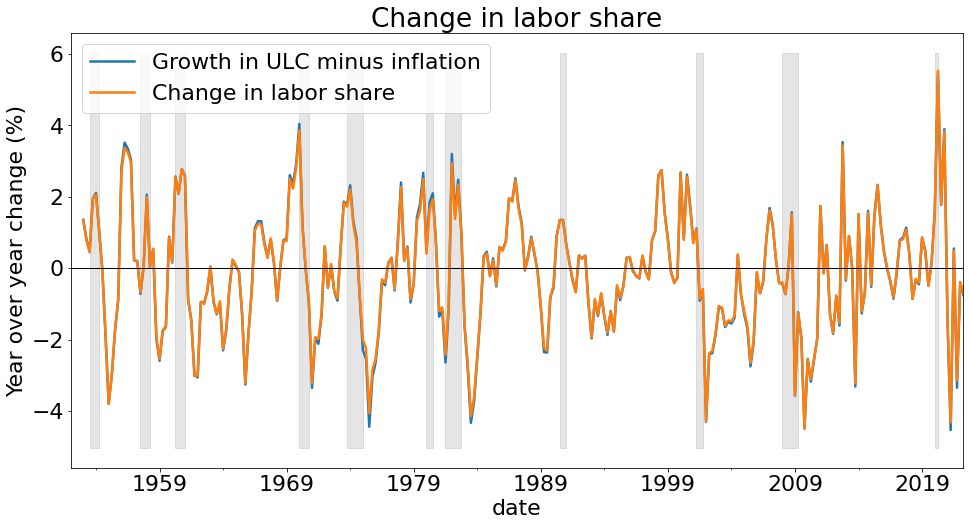

In [58]:
labsharechq=100*(series['laborshare']-series['laborshare'].shift(4))/series['laborshare'].shift(4)

plt.figure
(ulcyoy-deflyoyq).plot(label=r'Growth in ULC minus inflation')
labsharechq.plot(label=r'Change in labor share')
yl, yh = plt.ylim()
plt.title(r'Change in labor share')
plt.ylabel(r'Year over year change (%)')
plt.legend()
plt.axhline(0, color='black', linewidth=1)
yl, yh = plt.ylim()
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
#plt.savefig(f'Export/us_infl.pdf', format='pdf', transparent=True);
plt.legend()


From this perspective, labor share is mostly acyclical but you do see it falling at the end of recessions and rising late in booms. 
- Digging into this, it comes from the cyclical pattern of $W/(Y/N)$ around a stable $P$, with wages clearly falling relative to productivity at the end of the 80s, 01 and 09 recessions and then rising at the end of booms. 
- Also, the big decline in the labor share we saw in the 00s comes from this big decline in wages at the end of the 01 recession that was never compensated by an increase in wages at the end of that boom (great recession got there too early for that?)

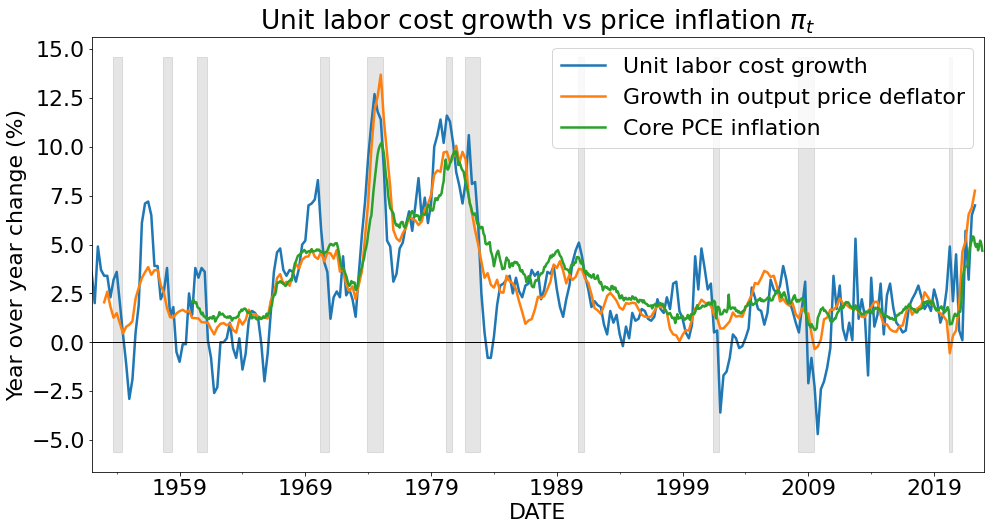

In [59]:
plt.figure
ulcyoy.plot(label=r'Unit labor cost growth')
deflyoyq.plot(label=r'Growth in output price deflator')
pceyoycore.plot(label=r'Core PCE inflation')
yl, yh = plt.ylim()
plt.title(r'Unit labor cost growth vs price inflation $\pi_t$')
plt.ylabel(r'Year over year change (%)')
yl, yh = plt.ylim()
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
#plt.savefig(f'Export/us_infl.pdf', format='pdf', transparent=True);
plt.legend()
plt.legend()
plt.axhline(0, color='black', linewidth=1)

This last graph is supposed to visualize the Larry Summers rule of thumb that ULC (or he would just say, wage inflation minus 1% productivity growth) is underlying core which you expect to pass through to core afer a bit (otherwise, at some obvious level, it must eat up corporate profit margins; but the data shows it's a bit subtle which inflation rate you want to use to see this)

### Investigating the summers rule

Let's look at the quarterly data directly to make progress. Should ditch the stuff above about using the percent change from year ago ULC data...

In [60]:

pceqoqcore=400*(seriesm['pcedeflcore']-seriesm['pcedeflcore'].shift(3))/seriesm['pcedeflcore'].shift(3)
deflqoq=400*(series['ydefl_nonfarm']-series['ydefl_nonfarm'].shift(1))/series['ydefl_nonfarm'].shift(1)
ulcqoq=400*(series['ulc_level']-series['ulc_level'].shift(1))/series['ulc_level'].shift(1)

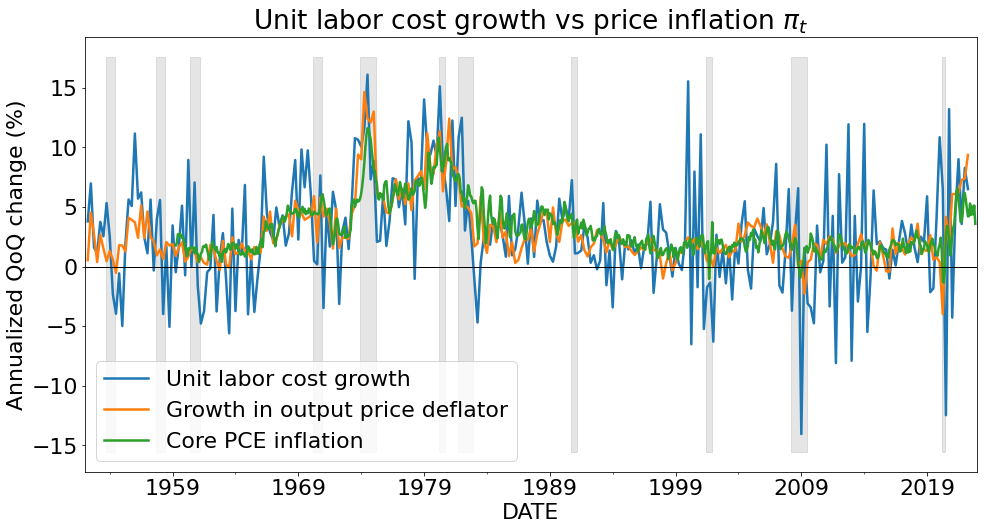

In [61]:
plt.figure
ulcqoq.plot(label=r'Unit labor cost growth')
deflqoq.plot(label=r'Growth in output price deflator')
pceqoqcore.plot(label=r'Core PCE inflation')
yl, yh = plt.ylim()
plt.title(r'Unit labor cost growth vs price inflation $\pi_t$')
plt.ylabel(r'Annualized QoQ change (%)')
yl, yh = plt.ylim()
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
#plt.savefig(f'Export/us_infl.pdf', format='pdf', transparent=True);
plt.legend()
plt.legend()
plt.axhline(0, color='black', linewidth=1);

In [62]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

xcov_Y = [crosscorr(ulcyoy, pceyoycore, lag=i) for i in range(12)]
print(xcov_Y)

xcov_Q = [crosscorr(ulcqoq, pceqoqcore, lag=i) for i in range(12)]
print(xcov_Q)

[0.8132439273495828, 0.810170145808305, 0.8021500711389268, 0.7939428163740245, 0.783927087753936, 0.766527958572012, 0.7539384620097741, 0.7335974804769771, 0.716124880906571, 0.7052526470868998, 0.6849269028008312, 0.6651315258884382]
[0.48654378790301606, 0.4922299524670593, 0.5053463253911752, 0.5021996344089024, 0.5133144016943817, 0.49224908154973307, 0.447860700228341, 0.3970780468629485, 0.4062393238272423, 0.4250100039350497, 0.433154606252861, 0.41461984515497785]


So at annual level these series are correlated 0.8. 

At quarterly level the relationship is noisier (because ULC very noisy) but there is actually a small hump shape in the autocorrelation with apparently a 5 quarter lagged passthrough, though it is very slight. 

### Interest rates

Text(0.5, 1.0, 'Interest rates')

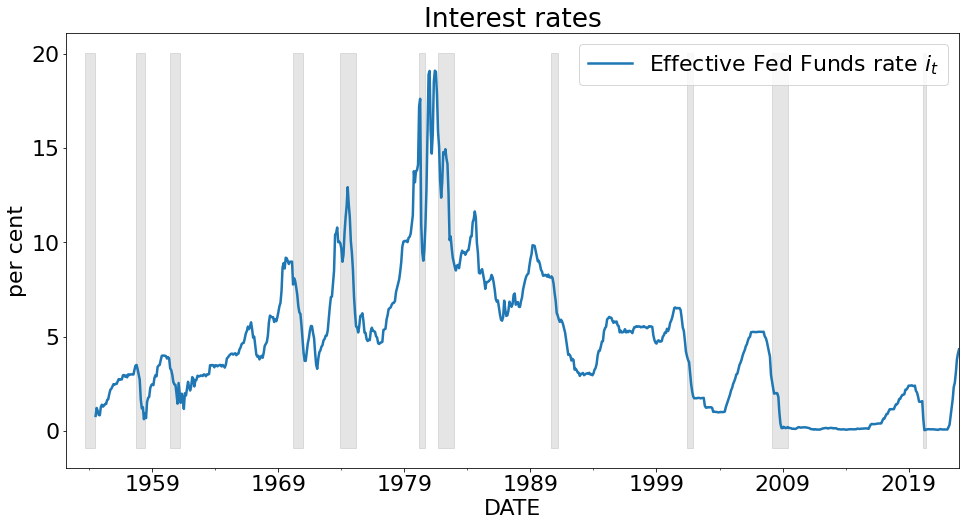

In [63]:
seriesm['fedfunds'].plot(label=r'Effective Fed Funds rate $i_t$')
#seriesm['ioer'].plot(label=r'on reserves $i_t^{res}$')
yl, yh = plt.ylim()
plt.ylabel('per cent')
plt.legend()
# Draw shaded for recession
plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
#plt.xlim('1980-01-01','2021-01-01')
plt.title(r'Interest rates')
#plt.savefig(f'Export/intrates.pdf', format='pdf', transparent=True);

In [64]:
#seriesd=seriesd.loc['2014-01-01':'2022-08-18']

Get recession indicator for whole period

In [65]:
seriesd['USREC'].interpolate(method='linear', inplace=True)
seriesd['dgs10'].interpolate(method='linear', inplace=True)
seriesd['breakeven10'].interpolate(method='linear', inplace=True)

Text(0.5, 1.0, 'US 10-year Treasury Rate')

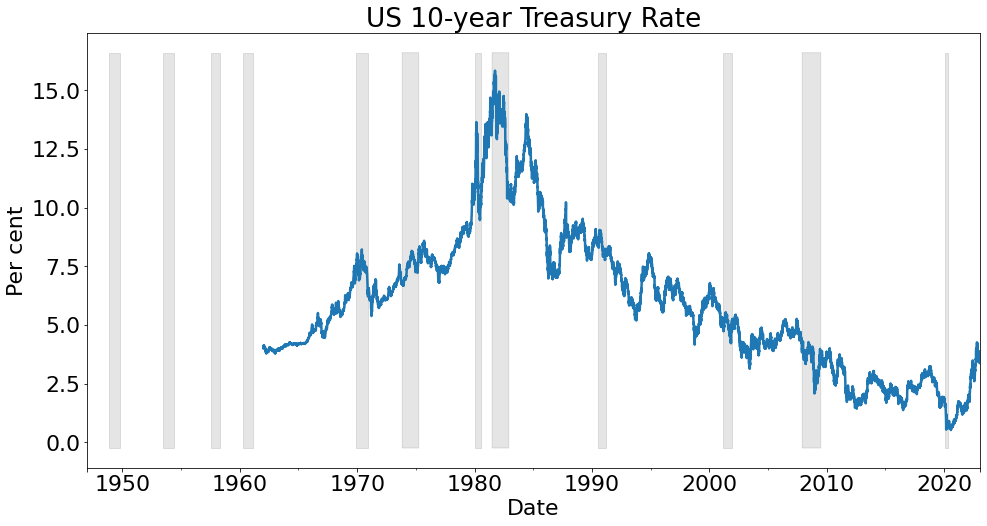

In [66]:
seriesd['dgs10'].plot()
# Draw shaded for recession
yl,yh=plt.ylim()
plt.fill_between(seriesd.index, yl, yh, where=seriesd['USREC'].values, color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Per cent')
plt.title('US 10-year Treasury Rate')
#plt.savefig(f'Export/treasury10year.pdf', format='pdf', transparent=True);

Text(0.5, 1.0, 'US 10-year Breakeven Inflation rate')

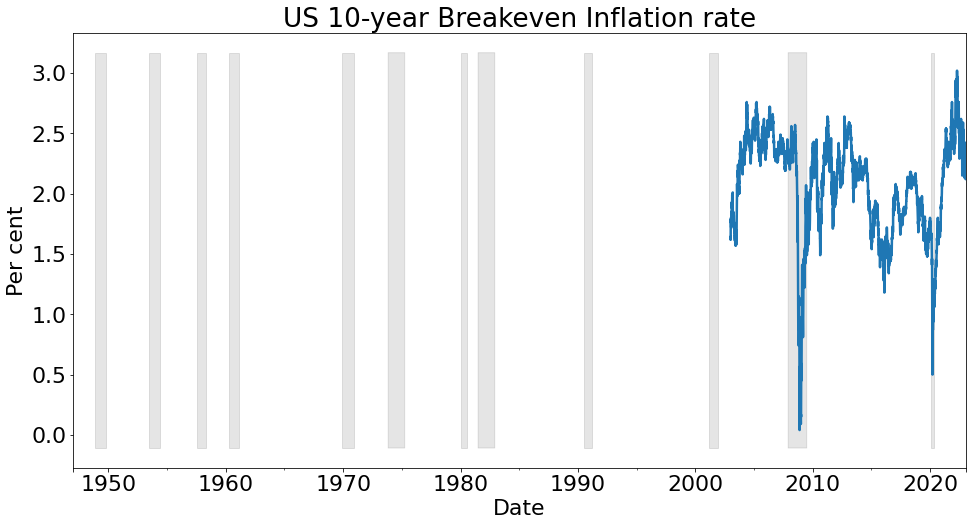

In [67]:
seriesd['breakeven10'].plot()
# Draw shaded for recession
yl,yh=plt.ylim()
plt.fill_between(seriesd.index, yl, yh, where=seriesd['USREC'].values, color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Per cent')
plt.title('US 10-year Breakeven Inflation rate')
#plt.savefig(f'Export/breakeven10year.pdf', format='pdf', transparent=True);